In [57]:

import pandas as pd
import numpy as np
import warnings



import re
import os
import json

import plotly.express as px

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, log_loss, roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

from sklearn.impute import KNNImputer

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(10,5)

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import shap
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.model_selection import GridSearchCV, train_test_split

import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
warnings.filterwarnings("ignore")

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('tested.csv')
entire_df = pd.concat([train_df, test_df], axis = 0)

Text(0.5, 1.0, 'Test Dataset: Missing Values')

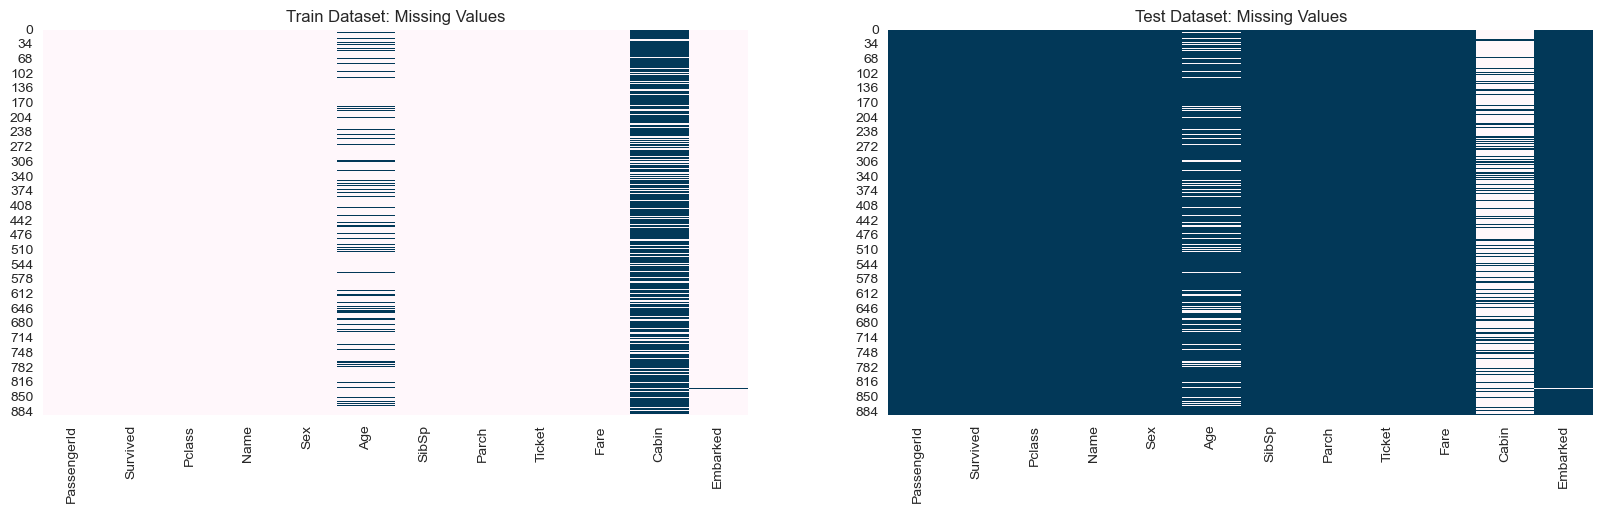

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu',ax=ax[0])
ax[0].set_title('Train Dataset: Missing Values')
sns.heatmap(train_df.isnull(), cbar=False, cmap='PuBu_r',ax=ax[1])
ax[1].set_title('Test Dataset: Missing Values')

In [4]:
# Show missing values for the entire dataset
def missing_tbl(df):
    tbl = pd.DataFrame()
    
    tbl['Column'] = df.columns
    tbl['Missing'] = [df[col].isnull().sum() for col in df.columns]
    tbl['Percentage'] = [round((df[col].isnull().sum() / df.shape[0])*100, 2) for col in df.columns]
    return tbl


missing_tbl(entire_df)

,Column,Missing,Percentage
0,PassengerId,0,0.00
1,Survived,0,0.00
2,Pclass,0,0.00
3,Name,0,0.00
4,Sex,0,0.00
5,Age,263,20.09
6,SibSp,0,0.00
7,Parch,0,0.00
8,Ticket,0,0.00
9,Fare,1,0.08


Text(0.5, 1.0, 'Age Distribution')

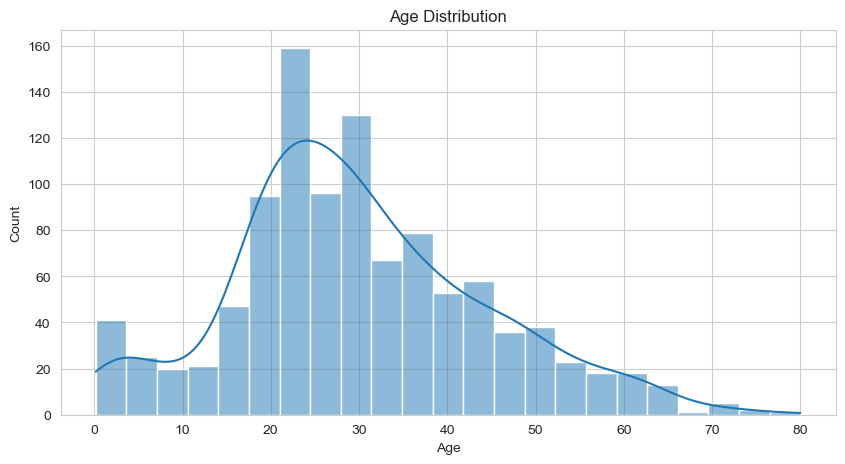

In [5]:
sns.histplot(data=entire_df['Age'], kde=True)
plt.title('Age Distribution')

In [6]:
# Create Title column by extracting title from Name column
def create_title(df):
    df = df.copy()
    df['Title'] = df['Name'].str.split(', ', expand=True)[1]
    df['Title'] = df['Title'].str.split('.', expand=True)[0]
    return df


entire_df = create_title(entire_df)

In [7]:
# Standardized Title column
def standardized_title(df):
    df = df.copy()
    
    # Unmarried woman
    unmarried_w = ['Mlle', 'Ms']
    for uw in unmarried_w:
        df['Title'].replace({uw : 'Miss'}, inplace=True)
    
    # Married woman
    married_w = ['Dona', 'Mme', 'Lady', 'the Countess']
    for mv in married_w:
        df['Title'].replace({mv : 'Mrs'}, inplace=True)
    
    # Man
    man = ['Don', 'Rev', 'Capt', 'Col', 'Major', 'Jonkheer', 'Sir']
    for m in man:
        df['Title'].replace({m : 'Mr'}, inplace=True)
        
    return df


# Apply function
entire_df = standardized_title(entire_df)

In [8]:
# Compute the correlation between Age and Categorical Features
from pandas import factorize

def cat_corr(feature):
    categories = ['Sex', 'Title', 'Embarked']
    print('Correlation between {} and Categorical Features:'.format(feature))
    for cat in categories:
        labels, categories = factorize(entire_df[cat])
        entire_df['labels'] = labels
        correlation = abs(entire_df[feature].corr(entire_df['labels']))
        print('{} : {:.4f}'.format(cat, correlation))
        entire_df.drop('labels', axis=1, inplace=True)
        
cat_corr('Age')

Correlation between Age and Categorical Features:
Sex : 0.0636
Title : 0.3821
Embarked : 0.0424


In [9]:
# Fill age with median 
median_age = entire_df.groupby('Title')['Age'].median()
def fill_age(title, age):
    if np.isnan(age): 
        return median_age.loc[title]
    else:
        return age

    
# Replace nan age with median age based on Title
entire_df['Age'] = entire_df.apply(lambda x : fill_age(x['Title'], x['Age']), axis=1)   

In [10]:
# Fill fare with median 
def fill_fare(pclass, fare):
    median_fare = entire_df.groupby('Pclass')['Fare'].median()
    if np.isnan(fare):
        return median_fare.loc[pclass]
    else:
        return fare

# Replace nan Fare with median fare based on Pclass
entire_df['Fare'] = entire_df.apply(lambda x : fill_fare(x['Pclass'], x['Fare']), axis=1) 

In [11]:
entire_df['Embarked'].fillna(entire_df['Embarked'].mode()[0], inplace=True)

In [12]:
entire_df['Fam'] = entire_df['SibSp'] + entire_df['Parch'] + 1

In [13]:
train_df = (entire_df.iloc[0:891]).copy()
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fam
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,Mr,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,Miss,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.0,1,2,W./C. 6607,23.45,NaN,S,Miss,4
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,Mr,1
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,Mr,1


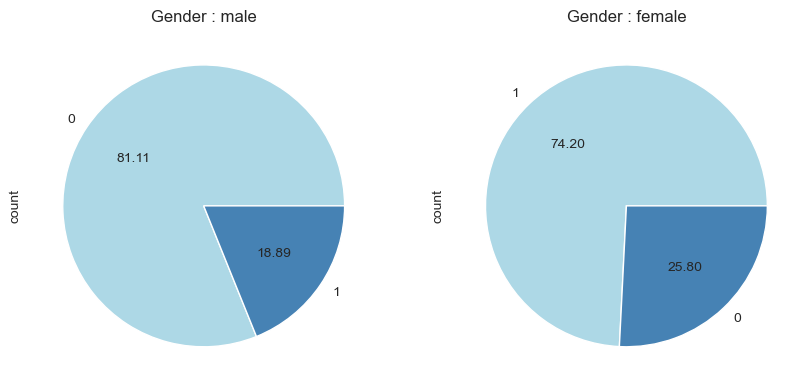

In [14]:
fig = plt.figure(figsize=(10,5))

i = 0
for gender in train_df['Sex'].unique():
    fig.add_subplot(1, 2, i+1)
    plt.title('Gender : {}'.format(gender))
    train_df.Survived[train_df['Sex'] == gender].value_counts().plot(kind='pie', autopct='%.2f', colors=['lightblue', 'steelblue'])
    i += 1

In [15]:
gender_mapping = {'male':0,
                  'female':1}

train_df['Sex'] = train_df['Sex'].apply(lambda x : gender_mapping.get(x)) 
entire_df['Sex'] = entire_df['Sex'].apply(lambda x : gender_mapping.get(x))

In [16]:
embark_mapping = {'S':0,
                  'Q':1,
                  'C':2}

train_df['Embarked'] = train_df['Embarked'].apply(lambda x : embark_mapping.get(x))
entire_df['Embarked'] = entire_df['Embarked'].apply(lambda x : embark_mapping.get(x))

In [17]:
title_mapping = {'Mr':0,
                 'Dr':1,
                 'Master':2,
                 'Miss':3,
                 'Mrs':4}

train_df['Title'] = train_df['Title'].apply(lambda x : title_mapping.get(x)) 
entire_df['Title'] = entire_df['Title'].apply(lambda x : title_mapping.get(x))

In [18]:
fam_mapping = {11:0,
               8:0,
               6:2,
               5:3,
               1:4,
               7:5,
               2:6,
               3:7,
               4:8}

train_df['Fam'] = train_df['Fam'].apply(lambda x : fam_mapping.get(x)) 
entire_df['Fam'] = entire_df['Fam'].apply(lambda x : fam_mapping.get(x))

In [19]:
from sklearn.preprocessing import OrdinalEncoder

features = ['Name', 'Ticket']

for feat in features:
    entire_df[feat] = OrdinalEncoder().fit_transform(entire_df[feat].values.reshape(-1, 1))

In [20]:


features = ['Name', 'Pclass', 'Age', 'Sex', 'Fare', 'SibSp', 'Parch', 'Ticket','Embarked', 'Fam', 'Title']

for feat in features:
    entire_df[feat] = MinMaxScaler().fit_transform(entire_df[feat].values.reshape(-1, 1))

In [21]:
entire_df.drop(['Cabin'], axis=1, inplace=True)

<Axes: >

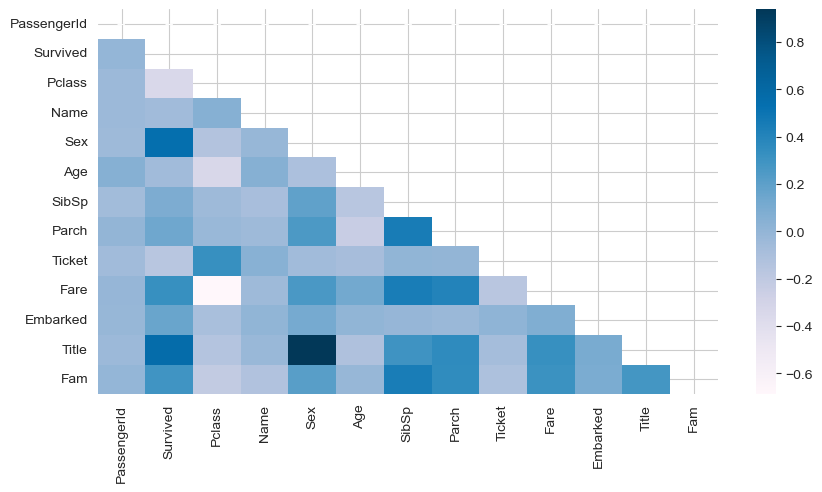

In [22]:
train_df = (entire_df.iloc[0:891]).copy()
corr_matrix = train_df.corr('spearman')
sns.heatmap(corr_matrix, cbar=True, annot=True,  mask = np.triu(np.ones_like(corr_matrix, dtype = bool)), cmap='PuBu')

In [56]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Fam'],
      dtype='object')

Random Forest:
  Accuracy (Train): 100.00%
  Accuracy (Test): 85.20%
  Log Loss (Train): 0.1024
  Log Loss (Test): 0.4145
--------------------------------------------------
SGD:
  Accuracy (Train): 63.17%
  Accuracy (Test): 60.99%
  Log Loss (Train): 13.2313
  Log Loss (Test): 14.0619
--------------------------------------------------
Linear SVC:
  Accuracy (Train): 62.13%
  Accuracy (Test): 61.88%
  Log Loss (Train): 3.2864
  Log Loss (Test): 3.8396
--------------------------------------------------
KNN:
  Accuracy (Train): 71.56%
  Accuracy (Test): 59.19%
  Log Loss (Train): 0.5488
  Log Loss (Test): 1.3272
--------------------------------------------------
Gaussian Naive Bayes:
  Accuracy (Train): 80.69%
  Accuracy (Test): 80.27%
  Log Loss (Train): 0.7692
  Log Loss (Test): 0.8834
--------------------------------------------------
SVC:
  Accuracy (Train): 62.13%
  Accuracy (Test): 60.09%
  Log Loss (Train): 0.4827
  Log Loss (Test): 0.5142
------------------------------------------

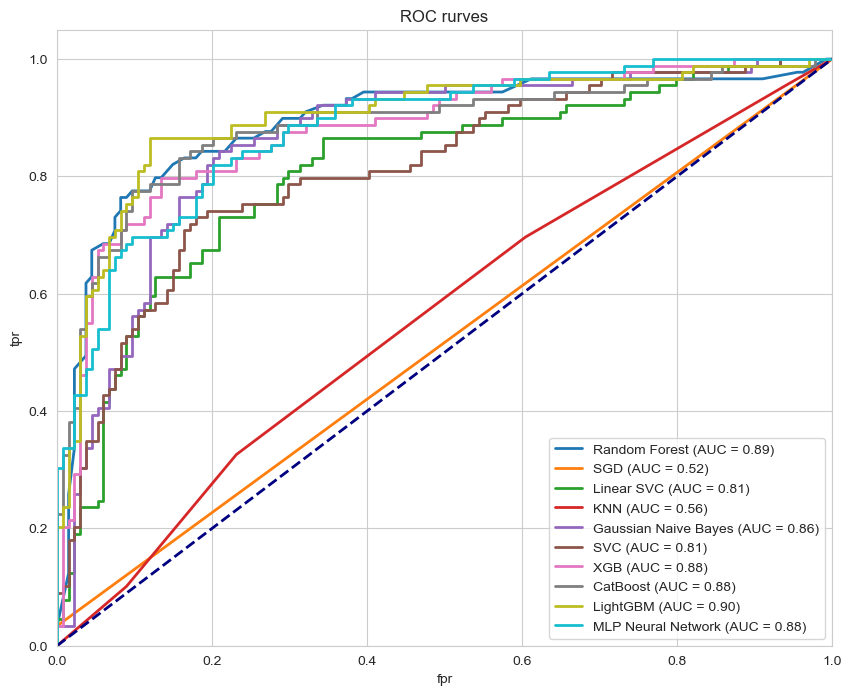

In [61]:
## lets evaluate validation sample

X = train_df[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Fam']]
y = train_df['Survived']


X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42)  
class ModelEvaluator:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        self.X_train = X_train
        self.Y_train = y_train
        self.X_test = X_valid
        self.Y_test = y_valid
        self.models = [
            ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
                        ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

    def calculate_log_loss(self, model):
        if hasattr(model, "predict_proba"):
            probas_train = model.predict_proba(self.X_train)
            probas_test = model.predict_proba(self.X_test)
        else:
            probas_train = model.decision_function(self.X_train)
            probas_test = model.decision_function(self.X_test)

        log_loss_train = log_loss(self.Y_train, probas_train)
        log_loss_test = log_loss(self.Y_test, probas_test)
        return log_loss_train, log_loss_test


    def train_and_evaluate_models(self):
        for name, model in self.models:
            model.fit(self.X_train, self.Y_train)
            
            # Accuracy
            acc_train = accuracy_score(self.Y_train, model.predict(self.X_train)) * 100
            acc_test = accuracy_score(self.Y_test, model.predict(self.X_test)) * 100
            
            # Log Loss
            log_loss_train, log_loss_test = self.calculate_log_loss(model)
            
            # Print results
            print(f"{name}:")
            print(f"  Accuracy (Train): {acc_train:.2f}%")
            print(f"  Accuracy (Test): {acc_test:.2f}%")
            print(f"  Log Loss (Train): {log_loss_train:.4f}")
            print(f"  Log Loss (Test): {log_loss_test:.4f}")
            print("-" * 50)
        
    

    def plot_roc_curve(self):
        plt.figure(figsize=(10, 8))

        for name, model in self.models:
            if hasattr(model, "predict_proba"):
                probas_ = model.predict_proba(self.X_test)[:, 1]
            else:
                probas_ = model.decision_function(self.X_test)

            fpr, tpr, _ = roc_curve(self.Y_test, probas_)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        # random roc to compare
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC rurves')
        plt.legend(loc="lower right")
        plt.show()


evaluator = ModelEvaluator(X_train, y_train, X_valid, y_valid)
evaluator.train_and_evaluate_models()
evaluator.plot_roc_curve()

In [62]:

models = [
 ("Random Forest", RandomForestClassifier()),
            ("SGD", SGDClassifier(loss='log')),
            ("Linear SVC", LinearSVC()),
            ('KNN', KNeighborsClassifier()),
            ("Gaussian Naive Bayes", GaussianNB()),
            ("SVC", SVC(probability=True)),
            ("XGB", xgb.XGBClassifier()),
            ("CatBoost", CatBoostClassifier(loss_function='Logloss', verbose=0)),
            ("LightGBM", lgb.LGBMClassifier()),
            ("MLP Neural Network", MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=42))
        ]

def calculate_log_loss(model, X_train, y_train, X_valid, y_valid):
    if hasattr(model, "predict_proba"):
        probas_train = model.predict_proba(X_train)
        probas_test = model.predict_proba(X_valid)
    else:
        probas_train = model.decision_function(X_train)
        probas_test = model.decision_function(X_valid)

    log_loss_train = log_loss(y_train, probas_train)
    log_loss_test = log_loss(y_valid, probas_test)
    return log_loss_train, log_loss_test

# Initialize lists to store the metrics
precision_train_list = []
precision_test_list = []
recall_train_list = []
recall_test_list = []
f1_train_list = []
f1_test_list = []
roc_auc_train_list = []
roc_auc_test_list = []
model_names = []
acc_train_list = []
acc_test_list = []
log_loss_train_list = []
log_loss_test_list = []

# Iterate through models and compute metrics
for name, model in models:
    try:
        model.fit(X_train, y_train)
        
        # Accuracy
        acc_train = accuracy_score(y_train, model.predict(X_train)) * 100
        acc_test = accuracy_score(y_valid, model.predict(X_valid)) * 100
        
        # Log Loss
        log_loss_train, log_loss_test = calculate_log_loss(model, X_train, y_train, X_valid, y_valid)
        
        # Precision
        precision_train = precision_score(y_train, model.predict(X_train))
        precision_test = precision_score(y_valid, model.predict(X_valid))
        
        # Recall
        recall_train = recall_score(y_train, model.predict(X_train))
        recall_test = recall_score(y_valid, model.predict(X_valid))
        
        # F1-Score
        f1_train = f1_score(y_train, model.predict(X_train))
        f1_test = f1_score(y_valid, model.predict(X_valid))
        
        # ROC AUC
        if hasattr(model, "predict_proba"):
            roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
            roc_auc_test = roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1])
        else:
            roc_auc_train = roc_auc_score(y_train, model.decision_function(X_train))
            roc_auc_test = roc_auc_score(y_valid, model.decision_function(X_valid))
        
        # Append the model name and metrics to the lists
        model_names.append(name)
        precision_train_list.append(precision_train)
        precision_test_list.append(precision_test)
        recall_train_list.append(recall_train)
        recall_test_list.append(recall_test)
        f1_train_list.append(f1_train)
        f1_test_list.append(f1_test)
        roc_auc_train_list.append(roc_auc_train)
        roc_auc_test_list.append(roc_auc_test)
        
        acc_train_list.append(acc_train)
        acc_test_list.append(acc_test)
        log_loss_train_list.append(log_loss_train)
        log_loss_test_list.append(log_loss_test)
        
    except Exception as e:
        # In case of any error, append np.nan or a default value
        print(f"Error with model {name}: {e}")
        model_names.append(name)
        precision_train_list.append(np.nan)
        precision_test_list.append(np.nan)
        recall_train_list.append(np.nan)
        recall_test_list.append(np.nan)
        f1_train_list.append(np.nan)
        f1_test_list.append(np.nan)
        roc_auc_train_list.append(np.nan)
        roc_auc_test_list.append(np.nan)
        
        acc_train_list.append(np.nan)
        acc_test_list.append(np.nan)
        log_loss_train_list.append(np.nan)
        log_loss_test_list.append(np.nan)

# Create DataFrame for model comparison
models_comparison = pd.DataFrame({
    'Model': model_names,
    'Score_train': acc_train_list,
    'Score_test': acc_test_list,
    'LogLoss_train': log_loss_train_list,
    'LogLoss_test': log_loss_test_list,
    'Precision_train': precision_train_list,
    'Precision_test': precision_test_list,
    'Recall_train': recall_train_list,
    'Recall_test': recall_test_list,
    'F1_train': f1_train_list,
    'F1_test': f1_test_list,
    'ROC_AUC_train': roc_auc_train_list,
    'ROC_AUC_test': roc_auc_test_list
})

# Sort the models by test accuracy
models_comparison = models_comparison.sort_values(by='Score_test', ascending=False)
models_comparison






,Model,Score_train,Score_test,LogLoss_train,LogLoss_test,Precision_train,Precision_test,Recall_train,Recall_test,F1_train,F1_test,ROC_AUC_train,ROC_AUC_test
8,LightGBM,100.000000,85.201794,0.047015,0.474098,1.000000,0.833333,1.000000,0.786517,1.000000,0.809249,1.000000,0.900470
7,CatBoost,95.059880,84.753363,0.184349,0.405414,0.978261,0.839506,0.889328,0.764045,0.931677,0.800000,0.990847,0.884957
0,Random Forest,100.000000,83.856502,0.103503,0.549222,1.000000,0.819277,1.000000,0.764045,1.000000,0.790698,1.000000,0.895103
6,XGB,100.000000,82.511211,0.026326,0.570896,1.000000,0.804878,1.000000,0.741573,1.000000,0.771930,1.000000,0.879675
4,Gaussian Naive Bayes,80.688623,80.269058,0.769199,0.883353,0.750000,0.736842,0.735178,0.786517,0.742515,0.760870,0.852393,0.861982
9,MLP Neural Network,80.838323,79.372197,0.458588,0.444196,0.793427,0.759036,0.667984,0.707865,0.725322,0.732558,0.854307,0.882609
1,SGD,63.173653,60.538117,13.273561,14.223504,1.000000,1.000000,0.027668,0.011236,0.053846,0.022222,0.513477,0.511236
5,SVC,62.125749,60.089686,0.503352,0.521814,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.831597,0.813181
3,KNN,71.556886,59.192825,0.548797,1.327173,0.677966,0.483333,0.474308,0.325843,0.558140,0.389262,0.747255,0.561253
2,Linear SVC,56.736527,56.053812,5.236805,5.690248,0.463855,0.473373,0.913043,0.898876,0.615180,0.620155,0.780199,0.774191


              precision    recall  f1-score   support

           0       0.86      0.90      0.88       134
           1       0.83      0.79      0.81        89

    accuracy                           0.85       223
   macro avg       0.85      0.84      0.84       223
weighted avg       0.85      0.85      0.85       223

Confusion Matrix of Orginal model:


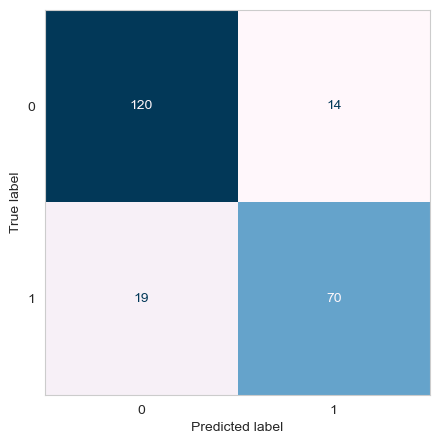

In [63]:


print(classification_report(y_valid, models[8][1].predict(X_valid)))
print('Confusion Matrix of Orginal model:')
ConfusionMatrixDisplay.from_predictions(y_valid, models[8][1].predict(X_valid), colorbar = False, cmap = 'PuBu')
plt.grid(False)

In [67]:
test_df = entire_df.iloc[891:, :][['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Fam']]
test_df = entire_df.iloc[891:][['Survived']]

In [ ]:
test_df = entire_df.iloc[891:]
test_df = test_df[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Fam']]


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Fam
0,892,1.0,0.488515,0.0,0.430039,0.000,0.000000,0.405172,0.015282,0.5,0.0,0.500
1,893,1.0,0.969372,1.0,0.586622,0.125,0.000000,0.627155,0.013663,0.0,1.0,0.750
2,894,0.5,0.640888,0.0,0.774521,0.000,0.000000,0.198276,0.018909,0.5,0.0,0.500
3,895,1.0,0.978560,0.0,0.336089,0.000,0.000000,0.394397,0.016908,0.0,0.0,0.500
4,896,1.0,0.415773,1.0,0.273456,0.125,0.111111,0.364224,0.023984,0.0,1.0,0.875
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,1.0,0.862175,0.0,0.373669,0.000,0.000000,0.766164,0.015713,0.0,0.0,0.500
414,1306,0.0,0.682236,1.0,0.486409,0.000,0.000000,0.898707,0.212559,1.0,1.0,0.500
415,1307,1.0,0.800919,0.0,0.480145,0.000,0.000000,0.939655,0.014151,0.0,0.0,0.500
416,1308,1.0,0.939510,0.0,0.373669,0.000,0.000000,0.623922,0.015713,0.0,0.0,0.500


In [78]:
entire_df.iloc[891:, 1]

0      0
1      1
2      0
3      0
4      1
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 418, dtype: int64

In [71]:
test_df = entire_df.iloc[891:]
test_df = test_df[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Title', 'Fam']]

prediction = models[8][1].predict(test_df)

submission = pd.DataFrame(test_df['PassengerId'], columns=['PassengerId'])
submission['Survived'] = prediction

submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 9.8 KB


In [80]:
# Accuracy
print(accuracy_score(entire_df.iloc[891:, 1], prediction))

# Log Loss
print(log_loss(entire_df.iloc[891:, 1], prediction))

# Precision
print(precision_score(entire_df.iloc[891:, 1],prediction))

# Recall
print(recall_score(entire_df.iloc[891:, 1], prediction))


# F1-Score
print(f1_score(entire_df.iloc[891:, 1], prediction))



0.8564593301435407
5.173730151547917
0.8285714285714286
0.7631578947368421
0.7945205479452055


In [208]:
import optuna

In [209]:
##catboost validation + optuna
X_train_split, X_eval, Y_train_split, Y_eval = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 2, 7),
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 10),
    }


    model = CatBoostClassifier(**param, verbose=0)


    model.fit(X_train_split, Y_train_split, eval_set=(X_eval, Y_eval), early_stopping_rounds=50)


    y_pred_proba = model.predict_proba(X_test) 


    loss = log_loss(Y_test, y_pred_proba)
    
    return loss


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print('Best hyperparameters:', study.best_params)
print('Best log_loss:', study.best_value)


best_params = study.best_params
final_model = CatBoostClassifier(**best_params, verbose=0)
final_model.fit(X_train, Y_train)


predictions = final_model.predict(X_test)
print("Predictions on test dataset:", predictions)


vis.plot_param_importances(study)

[I 2024-12-04 23:31:35,471] A new study created in memory with name: no-name-1d8a99c7-daee-4a2a-ba95-12ac89ccf178


[I 2024-12-04 23:31:35,661] Trial 0 finished with value: 0.3392371974685728 and parameters: {'learning_rate': 0.27294957774620243, 'depth': 6, 'iterations': 781, 'reg_lambda': 3.130919849628908}. Best is trial 0 with value: 0.3392371974685728.
[I 2024-12-04 23:31:36,220] Trial 1 finished with value: 0.3271993390970891 and parameters: {'learning_rate': 0.011444284987167357, 'depth': 5, 'iterations': 1167, 'reg_lambda': 1.383627773815983}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:36,401] Trial 2 finished with value: 0.35385351406016624 and parameters: {'learning_rate': 0.24215885958400366, 'depth': 4, 'iterations': 627, 'reg_lambda': 8.728587391354395}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:36,557] Trial 3 finished with value: 0.357026024798522 and parameters: {'learning_rate': 0.13831164417100594, 'depth': 4, 'iterations': 1952, 'reg_lambda': 1.6438906376558426}. Best is trial 1 with value: 0.3271993390970891.
[I 2024-12-04 23:31:

Best hyperparameters: {'learning_rate': 0.2014577786654323, 'depth': 7, 'iterations': 1015, 'reg_lambda': 9.683956200134041}
Best log_loss: 0.3046558830988605
Predictions on test dataset: [1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 1 1 1 1 1
 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1
 0 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1]


In [404]:


def objective(trial):
    # Определяем гиперпараметры для XGBoost
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Количество деревьев
        'max_depth': trial.suggest_int('max_depth', 2, 5),  # Максимальная глубина дерева
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),  # Темп обучения
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),  # Пропорция данных для обучения
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),  # Пропорция признаков для каждого дерева
        'gamma': trial.suggest_float('gamma', 0, 10),  # Регуляризация по величине разницы
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # Регуляризация L2
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # Регуляризация L1
    }

    # Создание модели с выбранными гиперпараметрами
    model = xgb.XGBClassifier(**param, random_state=42)

    # Используем кросс-валидацию для оценки модели
    f1_scores = cross_val_score(model, X_train, Y_train, scoring='f1', cv=5)  # 5-фолд кросс-валидация

    # Возвращаем среднее значение F1-score
    return 1 - np.mean(f1_scores)  # Мы минимизируем значение, поэтому возвращаем 1 - F1

# Создание объекта исследования
study = optuna.create_study(direction='minimize')  # Мы минимизируем 1 - F1, что эквивалентно максимизации F1
study.optimize(objective, n_trials=500)

print('Best hyperparameters:', study.best_params)
print('Best F1 score:', 1 - study.best_value)

# Извлекаем лучшие гиперпараметры и обучаем финальную модель
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params, random_state=42)
final_model.fit(X_train, Y_train)

# Прогнозируем на тестовой выборке
predictions = final_model.predict(X_test)
print("Predictions on test dataset:", predictions)

# Отображаем важность параметров
optuna.visualization.plot_param_importances(study)


[I 2024-12-05 11:08:15,243] A new study created in memory with name: no-name-b050a841-d0d5-49b7-89d9-dcdc7014fa5a
[I 2024-12-05 11:08:15,979] Trial 0 finished with value: 0.2485605625267734 and parameters: {'n_estimators': 345, 'max_depth': 4, 'learning_rate': 0.08978211909410559, 'subsample': 0.7906814172870996, 'colsample_bytree': 0.7983927642002047, 'gamma': 8.340511650823208, 'reg_lambda': 6.136555733862428, 'reg_alpha': 3.7780208690281336}. Best is trial 0 with value: 0.2485605625267734.
[I 2024-12-05 11:08:16,577] Trial 1 finished with value: 0.2485605625267734 and parameters: {'n_estimators': 179, 'max_depth': 5, 'learning_rate': 0.1558211233953881, 'subsample': 0.8407784146355031, 'colsample_bytree': 0.6832342909800707, 'gamma': 7.827694309031287, 'reg_lambda': 7.312108003049019, 'reg_alpha': 1.8497914334931953}. Best is trial 0 with value: 0.2485605625267734.
[I 2024-12-05 11:08:16,773] Trial 2 finished with value: 0.2547261141468704 and parameters: {'n_estimators': 108, 'max_

Best hyperparameters: {'n_estimators': 360, 'max_depth': 5, 'learning_rate': 0.1455428835432411, 'subsample': 0.975290327166701, 'colsample_bytree': 0.935881038812509, 'gamma': 6.438280950103595, 'reg_lambda': 1.3017731085696718, 'reg_alpha': 0.21682691499698006}
Best F1 score: 0.7824965408228199
Predictions on test dataset: [0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 

Using 891 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/418 [00:00<?, ?it/s]

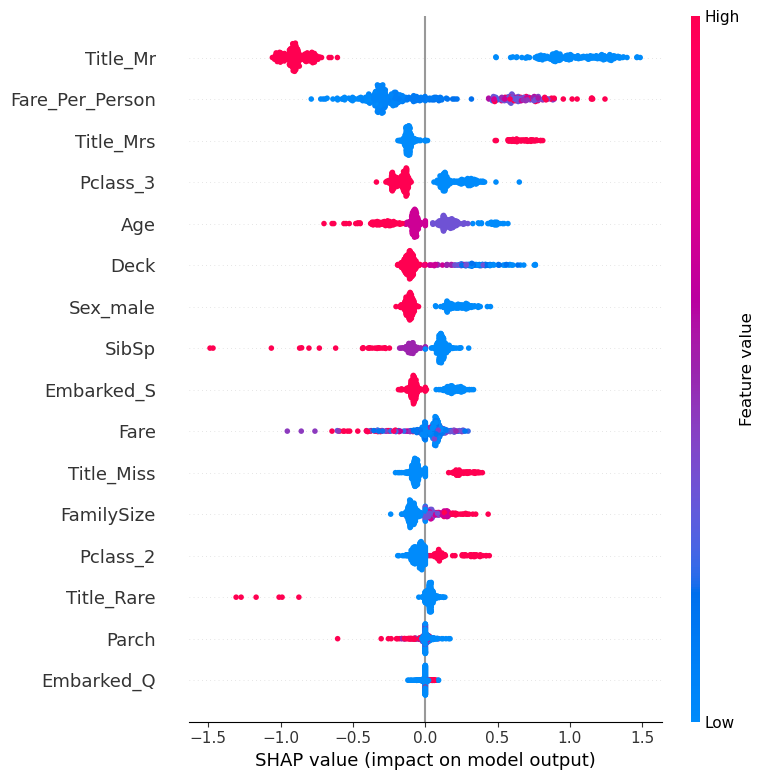

In [919]:
explainer = shap.KernelExplainer(final_model.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test, nsamples=100)  
shap.summary_plot(shap_values[1], X_test)

In [85]:
submission = pd.DataFrame({
        "PassengerId": pd.read_csv('test.csv')['PassengerId'],
        "Survived": prediction
    })
submission.to_csv('submission_last_rfm.csv', index=False)

In [87]:
submission.to_csv('submission_last_rfm_2.csv', index=False)

In [406]:
y_pred =  final_model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, models[6][1].predict(x_test)))
print(log_loss(y_test, models[6][1].predict_proba(x_test)[:, 1]))

0.8325358851674641
0.4173003927154396


In [407]:
print(accuracy_score(Y_test,y_pred))
print(f1_score(Y_test, y_pred))


0.9641148325358851
0.9498327759197324
